Load dataframes with acf and calculate tau

In [34]:
import pandas as pd
import numpy as np
from scipy.optimize import curve_fit, OptimizeWarning
from sklearn.metrics import r2_score
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

import warnings

### Get the data

In [48]:
area = 'pfp' #pfp

In [49]:
results_folder = 'D:\\projects_q_30_10_2024\\isttc\\results\\monkey\\fixation_period_1000ms\\non_binned\\' + area + '\\acf\\'
save_folder = 'D:\\projects_q_30_10_2024\\isttc\\results\\monkey\\fixation_period_1000ms\\non_binned\\' + area + '\\taus\\'

acf_average_trial_sttc_df_ = pd.read_pickle(results_folder + 'acf_average_trial_sttc_50ms_20lags_df.pkl')

# todo - store constrained info in a nice way
sua_pfdl_trials_20_no_0_bins_1hz_df = pd.read_pickle('D:\\projects_q_30_10_2024\\isttc\\results\\monkey\\fixation_period_1000ms\\sua_pfp_trials_20_no_0_bins_1hz_df.pkl')
units_more_1hz_l = sua_pfdl_trials_20_no_0_bins_1hz_df['unit_id'].unique()
n_units_more_1hz_l = len(units_more_1hz_l)
print(n_units_more_1hz_l)

acf_average_trial_pearsonr_df = acf_average_trial_pearsonr_df_[acf_average_trial_pearsonr_df_['unit_id'].isin(units_more_1hz_l)].copy()
len(acf_average_trial_pearsonr_df['unit_id'].unique())

318


318

### Calculate tau

In [37]:
def func_single_exp(x, a, b, c):
    """
    Exponential function to fit the data.
    :param x: 1d array, independent variable
    :param a: float, parameter to fit
    :param b: float, parameter to fit
    :param c: float, parameter to fit
    :return: callable
    """
    return a * np.exp(-b * x) + c


def fit_single_exp(ydata_to_fit_, start_idx_=1):
    """
    Fit function func_exp to data using non-linear least square.

    todo check that - important point: Fit is done from the first ACF value (acf[0] is skipped, it is done like this
    in the papers, still not sure)

    :param ydata_to_fit_: 1d array, the dependant data to fit
    :param start_idx_: int, index to start fitting from
    :return: fit_popt, fit_pcov, tau, fit_r_squared
    """
    t = np.linspace(start_idx_, len(ydata_to_fit_)-1, len(ydata_to_fit_)-1).astype(int)

    with warnings.catch_warnings():
        warnings.filterwarnings('error')
        try:
            popt, pcov = curve_fit(func_single_exp, t, ydata_to_fit_[start_idx_:], maxfev=1000000000) # I used 5000, now it is like in Siegle
            fit_popt = popt
            fit_pcov = pcov
            tau = 1 / fit_popt[1]
            # fit r-squared
            y_pred = func_single_exp(t, *popt)
            fit_r_squared = r2_score(ydata_to_fit_[start_idx_:], y_pred)
        except RuntimeError as e:
            print('RuntimeError: {}'. format(e))
            fit_popt, fit_pcov, tau, fit_r_squared = np.nan, np.nan, np.nan, np.nan
        except OptimizeWarning as o:
            print('OptimizeWarning: {}'. format(o))
            fit_popt, fit_pcov, tau, fit_r_squared = np.nan, np.nan, np.nan, np.nan
        except RuntimeWarning as re:
            print('RuntimeWarning: {}'. format(re))
            fit_popt, fit_pcov, tau, fit_r_squared = np.nan, np.nan, np.nan, np.nan
        except ValueError as ve:
            print('ValueError: {}'. format(ve))
            print('Possible reason: acf contains NaNs, low spike count')
            fit_popt, fit_pcov, tau, fit_r_squared = np.nan, np.nan, np.nan, np.nan

    return fit_popt, fit_pcov, tau, fit_r_squared

In [38]:
def calc_tau(acf_df_, acf_cols_):
    acf_2d = acf_df_[acf_cols_].values
    n_units = acf_2d.shape[0]
    print('Calculating taus for {}'.format(acf_2d.shape))
    
    fit_popt_a_l, fit_popt_b_l, fit_popt_c_l = [],[],[]
    fit_tau_l = []
    fit_r_squared_l = []
    
    for i in range(n_units):
        fit_popt, fit_pcov, tau, fit_r_squared = fit_single_exp(acf_2d[i,:], start_idx_=1)
        if  type(fit_popt) == np.ndarray:
            fit_popt_a_l.append(fit_popt[0])
            fit_popt_b_l.append(fit_popt[1])
            fit_popt_c_l.append(fit_popt[2])
        else:
            fit_popt_a_l.append(np.nan)
            fit_popt_b_l.append(np.nan)
            fit_popt_c_l.append(np.nan)
        fit_tau_l.append(tau)
        fit_r_squared_l.append(fit_r_squared)
    
    data_df = np.vstack((fit_popt_a_l, fit_popt_b_l, fit_popt_c_l, fit_tau_l, fit_r_squared_l)).T
    tau_df = pd.DataFrame(data_df, columns=['fit_a', 'fit_b', 'fit_c','tau', 'r_squared'])
    tau_df.insert(0, 'unit_id', acf_df_['unit_id'].values)
    # tau_df.insert(1, 'trial_id', acf_proper_df['trial_id'].values)
    tau_df['tau_ms'] = tau_df['tau'] * 50

    return tau_df

In [50]:
n_lags = 20
acf_cols = ['acf_' + str(i) for i in range(n_lags)]

#### Calc tau (for acf/Pearson) for average over trials and conditions (1 tau per unit)

In [ ]:
tau_acf_proper_trial_mean_df = calc_tau(acf_proper_trial_mean_df, acf_cols)

In [ ]:
tau_acf_proper_trial_mean_df.query('tau_ms > 0 and tau_ms <= 1000').describe()

In [ ]:
tau_acf_pearsonr_trial_mean_df = calc_tau(acf_pearsonr_trial_mean_df, acf_cols[:-1])

In [ ]:
tau_acf_pearsonr_trial_mean_df.query('tau_ms > 0 and tau_ms <= 1000').describe()

#### Calc tau (acf/Pearson) per trial (multiple taus per unit)

In [ ]:
tau_acf_proper_df = calc_tau(acf_proper_df, acf_cols)

In [ ]:
tau_acf_proper_df.query('tau_ms > 0 and tau_ms <= 1000').describe()

In [ ]:
tau_acf_pearsonr_df = calc_tau(acf_pearsonr_df, acf_cols[:-1])

In [ ]:
tau_acf_pearsonr_df.query('tau_ms > 0 and tau_ms <= 1000').describe()

#### Calc tau on acf as in Siegle (they use Pearson) - trial average

In [51]:
tau_acf_average_trial_pearsonr_df = calc_tau(acf_average_trial_pearsonr_df, acf_cols)

Calculating taus for (318, 20)


In [52]:
tau_acf_average_trial_pearsonr_df.query('tau_ms > 0 and tau_ms <= 1000').describe()

,unit_id,fit_a,fit_b,fit_c,tau,r_squared,tau_ms
count,246.000000,246.000000,246.000000,246.000000,246.000000,246.000000,246.000000
mean,279.191057,-224.436907,2.662323,0.105816,3.063146,0.413089,153.157304
std,162.139623,4847.578545,4.241562,0.127597,3.448484,0.326478,172.424204
min,0.000000,-28266.162457,0.055746,-0.163657,0.072853,0.000000,3.642630
25%,141.750000,0.093704,0.244860,0.008715,0.527658,0.093788,26.382906
50%,272.000000,0.197014,0.502034,0.072027,1.992063,0.393223,99.603141
75%,441.000000,0.337739,1.895257,0.165618,4.084042,0.723775,204.202105
max,542.000000,49751.635855,13.726346,0.534107,17.938646,0.979933,896.932301


In [53]:
tau_acf_average_trial_pearsonr_df.to_pickle(save_folder + 'tau_acf_average_trial_sttc_df_constrained_input_50ms_20lags_df.pkl')

#### One tau per area 

2 methods of doing that:
* average ACF over units and fit
* fit using all ACFs from all neurons

In [43]:
def calc_tau_area(acf_df_, acf_cols_, start_idx_=1):
    acf_2d = acf_df_[acf_cols_].values
    print(acf_2d.shape)
    
    t = np.linspace(start_idx_, acf_2d.shape[1]-start_idx_, acf_2d.shape[1]-start_idx_).astype(int)
    # print(t)
    
    # make 1d for curve_fit
    acf_1d = np.hstack(acf_2d[:,1:])
    print(acf_1d.shape)
    t_1d = np.tile(t, reps=acf_2d.shape[0])
    print(t_1d.shape)
    
    popt, pcov = curve_fit(func_single_exp, t_1d, acf_1d, maxfev=1000000000) # I used 5000, now it is like in Siegle
    tau = 1 / popt[1]
    
    # fit r-squared
    y_pred = func_single_exp(t_1d, *popt)
    fit_r_squared = r2_score(acf_1d, y_pred)

    return tau, popt, fit_r_squared

In [44]:
def calc_tau_area_mean(acf_df_, acf_cols_, start_idx_=1):
    acf_2d = acf_df_[acf_cols_].values
    acf_mean = np.nanmean(acf_2d, axis=0)
    
    t = np.linspace(start_idx_, len(acf_mean)-1, len(acf_mean)-1).astype(int)
    # print(t)
    
    popt, pcov = curve_fit(func_single_exp, t, acf_mean[1:], maxfev=1000000000) # I used 5000, now it is like in Siegle
    tau = 1 / popt[1]
    
    # fit r-squared
    y_pred = func_single_exp(t, *popt)
    fit_r_squared = r2_score(acf_mean[1:], y_pred)

    return tau, popt, fit_r_squared

In [54]:
# using Siegle style ACFs (Pear)
tau_avg_trial_pearsonr, popt_avg_trial_pearsonr, fit_r_square_avg_trial_pearsonr = calc_tau_area(acf_average_trial_pearsonr_df.dropna(), acf_cols)
print('tau_avg_trial_pearsonr {}, fit_r_square_avg_trial_pearsonr {}'.format(tau_avg_trial_pearsonr*50, fit_r_square_avg_trial_pearsonr))

tau_avg_trial_pearsonr_v2, popt_avg_trial_pearsonr_v2, fit_r_square_avg_trial_pearsonr_v2 = calc_tau_area_mean(acf_average_trial_pearsonr_df.dropna(), 
                                                                                                               acf_cols)
print('tau_avg_trial_pearsonr {}, fit_r_square_avg_trial_pearsonr {}'.format(tau_avg_trial_pearsonr_v2*50, fit_r_square_avg_trial_pearsonr_v2))

(318, 20)
(6042,)
(6042,)
tau_avg_trial_pearsonr 235.07649147963448, fit_r_square_avg_trial_pearsonr 0.046601019011519695
tau_avg_trial_pearsonr 235.06840729698908, fit_r_square_avg_trial_pearsonr 0.9921968967217002


In [ ]:
# using unit mean ACFs
tau_acf_proper_tr_mean, popt_acf_proper_tr_mean, fit_r_square_acf_proper_tr_mean = calc_tau_area(acf_proper_trial_mean_df.dropna(), acf_cols)
print('tau_acf_proper_tr_mean {}, fit_r_square_acf_proper_tr_mean {}'.format(tau_acf_proper_tr_mean*50, fit_r_square_acf_proper_tr_mean))

tau_acf_proper_tr_mean_v2, popt_acf_proper_tr_mean_v2, fit_r_square_acf_proper_tr_mean_v2 = calc_tau_area_mean(acf_proper_trial_mean_df.dropna(), acf_cols)
print('tau_acf_proper_tr_mean_v2 {}, fit_r_square_acf_proper_tr_mean_v2 {}'.format(tau_acf_proper_tr_mean_v2*50, fit_r_square_acf_proper_tr_mean_v2))

In [ ]:
acf_pearsonr_trial_mean_df.dropna()

In [ ]:
# using unit mean Pearsons
# HERE: dropping ACFs with NaNs!
tau_acf_pearsonr_tr_mean, popt_acf_pearsonr_tr_mean, fit_r_square_acf_pearsonr_tr_mean = calc_tau_area(acf_pearsonr_trial_mean_df.dropna(), acf_cols[:-1])
print('tau_acf_pearsonr_tr_mean {}, fit_r_square_acf_pearsonr_tr_mean {}'.format(tau_acf_pearsonr_tr_mean*50, fit_r_square_acf_pearsonr_tr_mean))

tau_acf_pearsonr_tr_mean_v2, popt_acf_pearsonr_tr_mean_v2, fit_r_square_acf_pearsonr_tr_mean_v2 = calc_tau_area_mean(acf_pearsonr_trial_mean_df.dropna(), acf_cols[:-1])
print('tau_acf_pearsonr_tr_mean_v2 {}, fit_r_square_acf_pearsonr_tr_mean_v2 {}'.format(tau_acf_pearsonr_tr_mean_v2*50, fit_r_square_acf_pearsonr_tr_mean_v2))

In [ ]:
df_type_l = ['acf_average_trial_pearsonr_df', 'acf_average_trial_pearsonr_df', 
             'acf_proper_trial_mean_df', 'acf_proper_trial_mean_df', 'acf_pearsonr_trial_mean_df', 'acf_pearsonr_trial_mean_df']
fit_type_l = ['fit_all', 'fit_mean', 'fit_all', 'fit_mean', 'fit_all', 'fit_mean']

tau_ms_l = [tau_avg_trial_pearsonr*50, tau_avg_trial_pearsonr_v2*50, tau_acf_proper_tr_mean*50, tau_acf_proper_tr_mean_v2*50, 
            tau_acf_pearsonr_tr_mean*50, tau_acf_pearsonr_tr_mean_v2*50]

r_squared_l = [fit_r_square_avg_trial_pearsonr, fit_r_square_avg_trial_pearsonr_v2, fit_r_square_acf_proper_tr_mean, fit_r_square_acf_proper_tr_mean_v2, 
            fit_r_square_acf_pearsonr_tr_mean, fit_r_square_acf_pearsonr_tr_mean_v2]

popt_a_l = [popt_avg_trial_pearsonr[0], popt_avg_trial_pearsonr_v2[0], 
            popt_acf_proper_tr_mean[0], popt_acf_proper_tr_mean_v2[0], 
            popt_acf_pearsonr_tr_mean[0], popt_acf_pearsonr_tr_mean_v2[0]]

popt_b_l = [popt_avg_trial_pearsonr[1], popt_avg_trial_pearsonr_v2[1], 
            popt_acf_proper_tr_mean[1], popt_acf_proper_tr_mean_v2[1], 
            popt_acf_pearsonr_tr_mean[1], popt_acf_pearsonr_tr_mean_v2[1]]

popt_c_l = [popt_avg_trial_pearsonr[2], popt_avg_trial_pearsonr_v2[2], 
            popt_acf_proper_tr_mean[2], popt_acf_proper_tr_mean_v2[2], 
            popt_acf_pearsonr_tr_mean[2], popt_acf_pearsonr_tr_mean_v2[2]]

tau_area_df = pd.DataFrame(np.vstack((df_type_l, fit_type_l, tau_ms_l, 
                                      r_squared_l, popt_a_l, popt_b_l, popt_c_l)).T, 
                           columns=['df_type', 'fit_type', 'tau_ms', 'r_squared','popt_a', 'popt_b', 'popt_c'])
tau_area_df

In [55]:
def plot_acf_area_fit(acf_df_, acf_cols_, tau_ms_, popt_, tau_ms_v2_, popt_v2_, start_idx_=1, save_fig=False, file_name=None):
    fig, axes = plt.subplots(1,2, figsize=(12,4))

    n_lags = 20
    t = np.linspace(start_idx_, n_lags-1, n_lags-1).astype(int)
    t_labels = np.linspace(50, 950, n_lags-1).astype(int)
    
    # plot 2 fits
    acf_2d = acf_df_[acf_cols_].values
    for i in range(acf_2d.shape[0]):
        axes[0].scatter(t, acf_2d[i,1:], s=1, color='steelblue')
    axes[0].plot(t, func_single_exp(t, popt_[0], popt_[1], popt_[2]), 'r-', label="Fitted Curve")
    axes[0].set_title('tau ' + str(np.round(tau_ms_ * 50,2)) + ', ' + str(acf_2d.shape[0]) + ' units')
    
    acf_2d_mean = np.nanmean(acf_2d, axis=0)
    axes[1].scatter(t, acf_2d_mean[1:], s=3, color='steelblue')
    axes[1].plot(t, func_single_exp(t, popt_v2_[0], popt_v2_[1], popt_v2_[2]), 'r-', label="Fitted Curve")
    axes[1].errorbar(t, acf_2d_mean[1:], stats.sem(acf_2d, axis=0)[1:], linestyle='None', marker='.')
    axes[1].set_title('tau ' + str(np.round(tau_ms_v2_ * 50,2)) + ', ' + str(acf_2d.shape[0]) + ' units')
    
    #axes[1].set_ylim([0, 0.25])
    
    for ax in axes.flat:
        ax.set_xticks(t)
        ax.set_xticklabels(t_labels, rotation=90)
        ax.set_xlabel('Time lag (ms)')
        ax.set_ylabel('Autocorrelation (a.u.)')  
    
    sns.despine()
    
    if save_fig:
        fig.savefig(file_name, bbox_inches='tight')

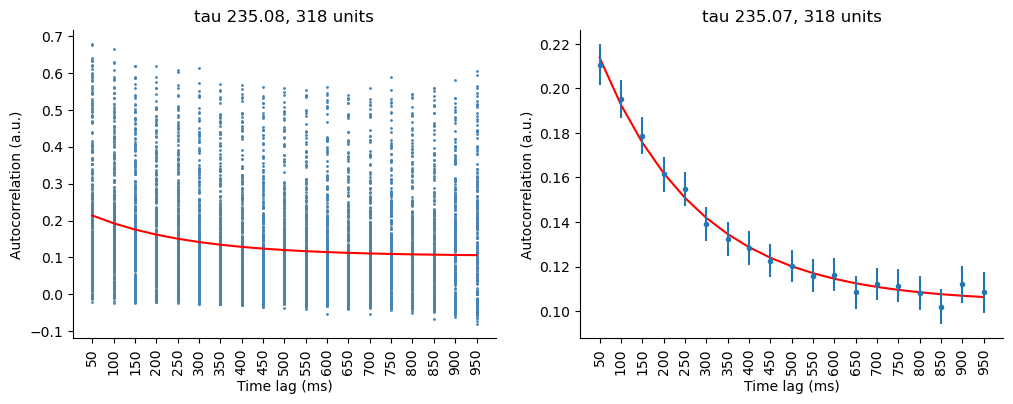

In [56]:
plot_acf_area_fit(acf_average_trial_pearsonr_df, acf_cols, 
                  tau_avg_trial_pearsonr, popt_avg_trial_pearsonr, 
                  tau_avg_trial_pearsonr_v2, popt_avg_trial_pearsonr_v2, 
                  1, True, save_folder + 'tau_avg_trial_sttc_50ms_20lags_area.png')

In [ ]:
plot_acf_area_fit(acf_proper_trial_mean_df, acf_cols, 
                  tau_acf_proper_tr_mean, popt_acf_proper_tr_mean, 
                  tau_acf_proper_tr_mean_v2, popt_acf_proper_tr_mean_v2, 
                  1, True, save_folder + 'tau_acf_proper_tr_mean_50ms_20lags_area.png')

In [ ]:
plot_acf_area_fit(acf_pearsonr_trial_mean_df, acf_cols[:-1], 
                  tau_acf_pearsonr_tr_mean, popt_acf_pearsonr_tr_mean, 
                  tau_acf_pearsonr_tr_mean_v2, popt_acf_pearsonr_tr_mean_v2, 
                  1, True, save_folder + 'tau_acf_pearsonr_tr_mean_50ms_20lags_area.png')

### Save all frames

In [ ]:
tau_acf_proper_df.to_pickle(save_folder + 'tau_acf_proper_df_constraint_input_50ms_20lags_df.pkl')
tau_acf_pearsonr_df.to_pickle(save_folder + 'tau_acf_pearsonr_df_constraint_input_50ms_20lags_df.pkl')

tau_acf_proper_trial_mean_df.to_pickle(save_folder + 'tau_acf_proper_trial_mean_constraint_input_50ms_20lags_df.pkl')
tau_acf_pearsonr_trial_mean_df.to_pickle(save_folder + 'tau_acf_pearsonr_trial_mean_constraint_input_50ms_20lags_df.pkl')

tau_acf_average_trial_pearsonr_df.to_pickle(save_folder + 'tau_acf_average_trial_pearsonr_df_constrained_input_50ms_20lags_df.pkl')

tau_area_df.to_pickle(save_folder + 'tau_area_df_constrained_input_50ms_20lags_df.pkl')